In [20]:
import matplotlib.pyplot as plt
import numpy as np
import xlrd
from arch.bootstrap import SPA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model


In [21]:
# read the data from the csv file /home/vishi/bolinger/22-05cumul_ohlc_diff_percent.csv

df = pd.read_csv('/home/vishi/bolinger/22-05cumul_ohlc_diff_percent.csv', index_col=0, parse_dates=True)
df.head()

,open,high,low,close,close_diff_percent,close_moving_avg,std,upper_bb,lower_bb,close_diff,close_scaled_down
DateTime,,,,,,,,,,,
2024-12-31 09:16:00,2355950,2356430,2354005,2355135,NaN,NaN,NaN,NaN,NaN,NaN,2355.135
2024-12-31 09:17:00,2355070,2356150,2354500,2355915,3.311912,NaN,NaN,NaN,NaN,780.0,2355.915
2024-12-31 09:18:00,2355980,2356025,2355100,2355405,-2.164764,NaN,NaN,NaN,NaN,-510.0,2355.405
2024-12-31 09:19:00,2355400,2357195,2355215,2356905,6.368332,NaN,NaN,NaN,NaN,1500.0,2356.905
2024-12-31 09:20:00,2356960,2357015,2355475,2355475,-6.067279,NaN,NaN,NaN,NaN,-1430.0,2355.475


In [22]:
def func_of_arima_1_1_1(t_1_data, t_2_data, ar_param, ma_param, prev_residual):
    """
    Calculate the ARIMA(1,1,1) value based on previous data and parameters.
    
    :param t_1_data: Previous time series data point (t-1)
    :param t_2_data: Previous time series data point (t-2)
    :param ar_param: AR parameter
    :param ma_param: MA parameter
    :param prev_residual: Previous residual
    :return: Computed value for the current time step
    """
    return ar_param * (t_1_data - t_2_data) + ma_param * prev_residual + t_1_data

def func_of_garch_1_1(omega, alpha, beta, prev_volatility, prev_residual):
    """
    Calculate the GARCH(1,1) value based on previous volatility and residuals.
    :param omega: Constant term
    :param alpha: Coefficient for lagged squared residuals
    :param beta: Coefficient for lagged volatility
    :param prev_volatility: Previous volatility
    :param prev_residual: Previous residual
    :return: Computed volatility for the current time step
    """
    return np.sqrt(omega + alpha * prev_residual ** 2 + beta * prev_volatility**2)


def forcast_next_minute(_20_minute_data, garch_fit, order_arima=(1, 1, 1), order_garch=(1, 1), predicted_volatility=[]):
    """
    Forecast the next minute using ARIMA and ARCH models.
    :param _20_minute_data: DataFrame with 20 minutes of data
    :param order_arima: Order of the ARIMA model
    :param order_arch: Order of the ARCH model
    :return: Forecasted value for the next minute
    """
    # Fit ARIMA model
    arima_model = ARIMA(_20_minute_data, order=order_arima)
    arima_fit = arima_model.fit()
    residual_np = np.array(arima_fit.resid)
    ma_param = arima_fit.maparams[0]
    ar_param = arima_fit.arparams[0]
    
    arima_forecast = func_of_arima_1_1_1(
        t_1_data=_20_minute_data.iloc[-1],
        t_2_data=_20_minute_data.iloc[-2],
        ar_param=ar_param,
        ma_param=ma_param,
        prev_residual=residual_np[-1]
    )

    garch_params = garch_fit.params
    omega = garch_params['omega']
    alpha = garch_params['alpha[1]']
    beta = garch_params['beta[1]']

    vol_garch = garch_fit.conditional_volatility
    if len(predicted_volatility) == 0:
        forecast_garch = func_of_garch_1_1(
            omega,
            alpha,
            beta,
            vol_garch[-1],
            residual_np[-1]
        )
    else:
        forecast_garch = func_of_garch_1_1(
            omega,
            alpha,
            beta,
            predicted_volatility[-1],
            residual_np[-1]
        )
    predicted_volatility.append(forecast_garch)

    return arima_forecast, forecast_garch, predicted_volatility

In [23]:
def rolling_forecast(df, window_size=20, order_arima=(1, 1, 1), order_arch=(1, 1), garch_fit=None):
    """
    Perform rolling forecast on the DataFrame.
    :param df: DataFrame with the data
    :param window_size: Size of the rolling window
    :param order_arima: Order of the ARIMA model
    :param order_arch: Order of the ARCH model
    :return: List of forecasted values
    """
    forecasts_mid = []
    forecast_vol = []
    predicted_volatility = []

    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")


    for i in range(window_size, len(df)):
        if i == len(df)//2:
            print("Halfway through the data, fitting GARCH model")
            print(predicted_volatility)
        _20_minute_data = df.iloc[i-window_size:i]
        arima_forecast, garch_forecast, predicted_volatility = forcast_next_minute(_20_minute_data,
                                                             garch_fit=garch_fit, 
                                                             order_arima=order_arima, 
                                                             order_garch=order_arch, 
                                                             predicted_volatility = predicted_volatility
                                                             )
        forecasts_mid.append(arima_forecast)
        forecast_vol.append(garch_forecast)  # Get the last forecasted varianc
    
    return forecasts_mid, forecast_vol

In [24]:
data = df["close_scaled_down"].loc["2025-01-31 15:11":"2025-02-05"]
data_to_garch = df["close_scaled_down"].loc["2024-12-31":"2025-02-01 09:00"]
data_to_garch = data_to_garch.dropna()
# fit the Arima model
arima_for_1_month = ARIMA(data_to_garch, order=(1, 1, 1))
arima_for_1_month_fit = arima_for_1_month.fit()

rsidual_for_1_month = np.array(arima_for_1_month_fit.resid)
# fit the Garch model
garch_for_1_month = arch_model(rsidual_for_1_month, vol='Garch', p=1, q=1)
garch_for_1_month_fit = garch_for_1_month.fit(disp="off")

vol_garch_for_1_month = garch_for_1_month_fit.conditional_volatility


forecasts_mid, forecast_vol = rolling_forecast(data, window_size=20, order_arima=(1, 1, 1), order_arch=(1, 1), garch_fit=garch_for_1_month_fit)


Halfway through the data, fitting GARCH model
[np.float64(0.8262368714124887), np.float64(0.8133333442188093), np.float64(1.0379435696205765), np.float64(1.1016637339062243), np.float64(0.8911986906009968), np.float64(0.8977017965072729), np.float64(0.8863772554707695), np.float64(0.8382065946301409), np.float64(0.8532267831170725), np.float64(0.8574601902299895), np.float64(0.8499200738493657), np.float64(0.8517857671717098), np.float64(0.9626232712821386), np.float64(0.8839158629599048), np.float64(0.8923256915517324), np.float64(0.8221301012208725), np.float64(1.5400532153823383), np.float64(1.769284516668724), np.float64(1.9395211629368492), np.float64(1.1813792890238155), np.float64(0.8940341336798519), np.float64(0.9453763467708718), np.float64(0.9758258613226394), np.float64(1.104982753518661), np.float64(0.9913383090965647), np.float64(0.8391458636371113), np.float64(0.8813727895448689), np.float64(1.4052321703776722), np.float64(0.9206844437142115), np.float64(0.88620794907013

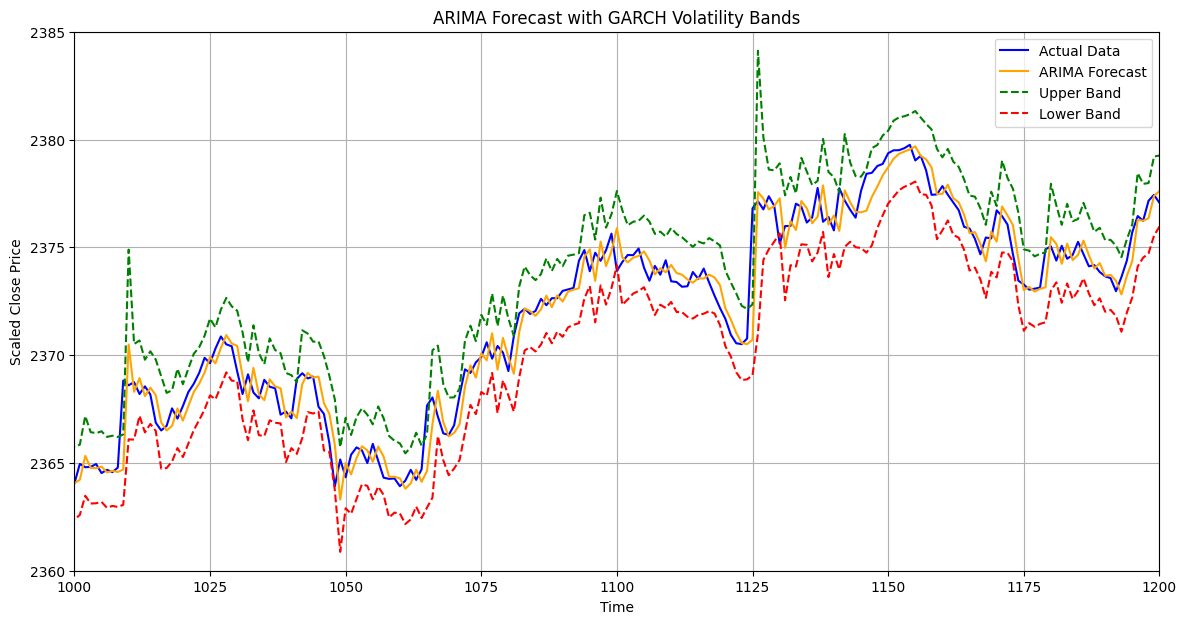

In [25]:
upper_band_arima = np.array(forecasts_mid) + 2 * np.array(forecast_vol)
lower_band_arima = np.array(forecasts_mid) - 2 * np.array(forecast_vol)
plt.figure(figsize=(14, 7))
plt.plot(np.array(df["close_scaled_down"].loc["2025-02-01 09:00":"2025-02-05"]), label='Actual Data', color='blue')
plt.plot(np.array(forecasts_mid), label='ARIMA Forecast', color='orange')
plt.plot(upper_band_arima, label='Upper Band', color='green', linestyle='--')
plt.plot(lower_band_arima, label='Lower Band', color='red', linestyle='--')

plt.legend()
plt.title('ARIMA Forecast with GARCH Volatility Bands')
plt.xlabel('Time')
# zoom between x axix 400 to 600
plt.xlim(1000,1200)
plt.ylim(2360,2385)
plt.ylabel('Scaled Close Price')
plt.grid()
plt.show()

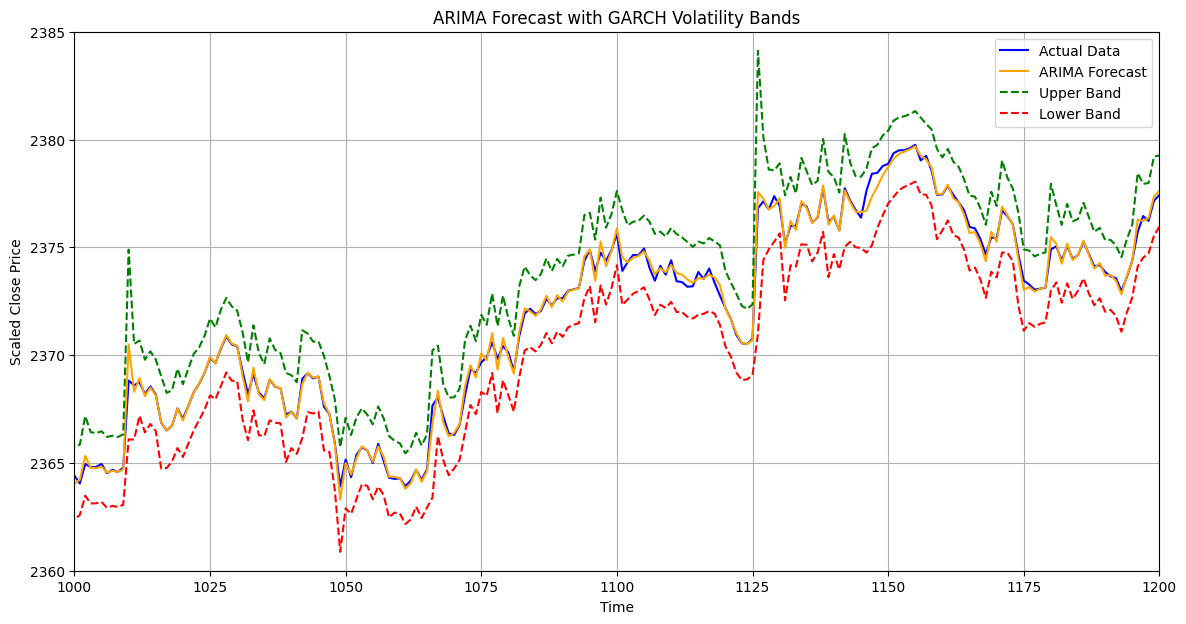

In [26]:
upper_band_arima = np.array(forecasts_mid) + 2 * np.array(forecast_vol)
lower_band_arima = np.array(forecasts_mid) - 2 * np.array(forecast_vol)
plt.figure(figsize=(14, 7))
plt.plot(np.array(df["close_scaled_down"].loc["2025-01-31 15:30":"2025-02-05"]), label='Actual Data', color='blue')
plt.plot(np.array(forecasts_mid), label='ARIMA Forecast', color='orange')
plt.plot(upper_band_arima, label='Upper Band', color='green', linestyle='--')
plt.plot(lower_band_arima, label='Lower Band', color='red', linestyle='--')

plt.legend()
plt.title('ARIMA Forecast with GARCH Volatility Bands')
plt.xlabel('Time')
# zoom between x axix 400 to 600
plt.xlim(1000,1200)
plt.ylim(2360,2385)
plt.ylabel('Scaled Close Price')
plt.grid()
plt.show()

In [27]:
len(forecasts_mid), len(forecast_vol),len(data) - 20

(1500, 1500, 1500)

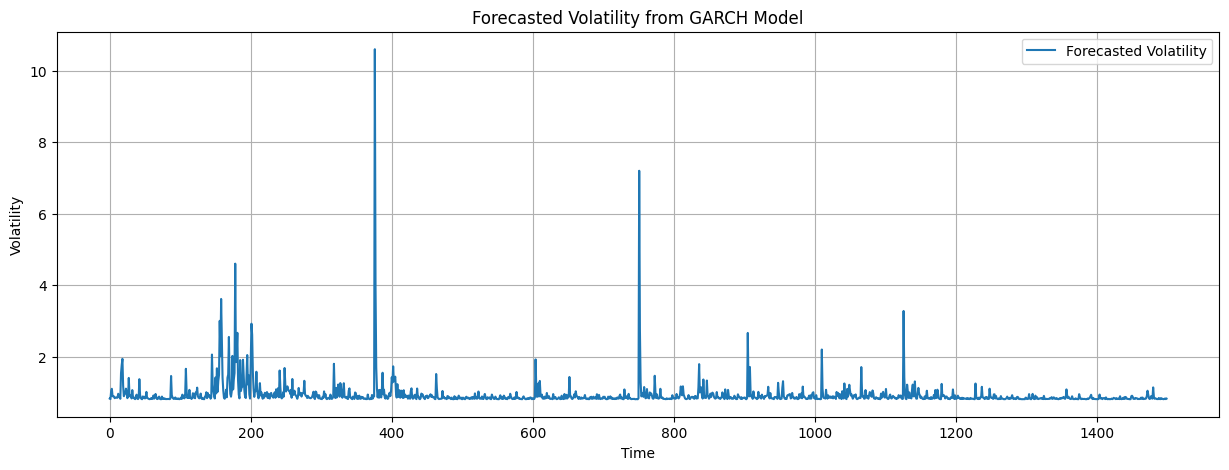

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(np.array(forecast_vol), label='Forecasted Volatility')

plt.title('Forecasted Volatility from GARCH Model')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()
